# 資料處理概述

本節課上半堂聚焦於一般型態資料處理，下半堂聚焦於空間資料處理。  
定位是**分享**TUIC常使用的資料處理方法，減少大家上網查詢的時間。但資料處理並無定式，大部分的資料處理也不複雜，因此我們採廣度優先且基礎的分享。  
.  
  
對於不熟悉python但看得懂的人，你可以先記得這裡有些code可以參考；對於熟悉python的人，你可以快速瀏覽本教材有沒有未看過的code，尤其是下半堂的空間處理，我們認為這是較多人未接觸過的部份；更進階的大大們，歡迎在slido中與大家分享更多的知識~
  
.
  
環境將使用Colab線上執行python，並主要使用pandas、geopandas操作。  
*(本競賽不限制資料處理方式，當資料不大也不需要自動化時，Excel也是不錯的工具。)*

**資料處理**是為了將資料處理成下個階段可以使用的形式，要做什麼處理完全取決於資料與下階段目標的差異。因此在正式處理資料前，建議確保以下流程:

1. Understanding Input and Output Data
2. Designing Processing Plans
3. Coding

Coding內容並無定式，以下僅提供我們常用的結構，請隨你的需求調整:

In [1]:
# 0.Set Config
# 1.Collection
# 2.Inspection
# 3.Rename
# 4.Define data type
# 5.Fill missing value
# 6.<... other process ...>
# 7.Select
# 8.Save

# 實作 - 原始資料初步清理轉換

本節課將實作2個資料流，另提供1個資料流自主練習。  
實作2個資料流如下，當中涉及的空間處理、處理成儀表板可讀格式，將在下半堂課繼續。  
.  
(*格式: [input data]+[input data] -> [output data]*)
* A.臺北市身心障礙者福利服務 -> 無障礙需求歷年趨勢
* B.臺北市身障設施+臺北市身障社區長照機構+村里界 -> 身障友善機構

## Install necessary packages

In [2]:
!pip install geocoder==1.38.1
!pip install geopandas==0.13.2
!pip install shapely==2.0.2
!pip install keplergl==0.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 56.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for keplergl: filename=keplergl-0.3.2-py2.py3-none-any.whl size=17922316 sha256=5c6769a9ce94fa22823cd63690b02fa0208f29865dea9764112f7c9d4a526a25
  Stored in directory: /root/.cache/pip/wheels/e5/e9/db/b8b8f2fcb5cb1cd7268d88959fce267bc00697cb8f50dcd0d9
Successfully built keplergl


In [3]:
# import and pre-load funtion
import json
import requests
import geopandas as gpd
import geocoder
import pandas as pd
from shapely.geometry import LineString, Point, Polygon

from google.colab import files
uploaded = files.upload()
%run func.py

Saving func.py to func.py


## A.臺北市身心障礙者福利服務 -> 無障礙需求歷年趨勢
*Colab預設路徑為`/content`，未指定路徑的下載、儲存、上傳檔案將在預設路徑下。*

### Designing Processing Plan

Processing Plan
* 修改欄位名，[]變成()
* 民國年修改成西元年
* 定義data type，具量詞欄位應為float
* 選擇指定欄位

In [4]:
# Input data- 臺北市身心障礙者福利服務
disability_welfare = get_datataipei_api('a09d5ff1-6b83-4bce-abbb-480b126db611')
disability_welfare.head(3)

,_id,_importdate,年別,住宿及照顧福利機構家數[家],住宿及照顧福利機構核定服務人數[人],住宿及照顧福利機構實際服務人數[人],福利服務中心家數[家],福利服務中心服務人次[人次],日間及住宿式照顧補助人次[人次],日間及住宿式照顧補助金額[元],...,職場手語翻譯服務人次[人次],職場手語翻譯服務男性人次[人次],職場手語翻譯服務女性人次[人次],職場聽打服務/申請案件數[件],職場聽打服務時間[小時],職場聽打服務人次[人次],職場聽打男性服務人次[人次],職場聽打女性服務人次[人次],醫療及醫療輔具補助人次[人次],醫療及醫療輔具補助金額[元]
0,1,"{'date': '2023-04-13 09:59:46.642404', 'timezo...",84年,20,-,1142,5,-,862,37007518,...,-,-,-,-,-,-,-,-,-,-
1,2,"{'date': '2023-04-13 09:59:46.655343', 'timezo...",85年,24,-,1417,-,-,1142,91367929,...,-,-,-,-,-,-,-,-,-,-
2,3,"{'date': '2023-04-13 09:59:46.656965', 'timezo...",86年,23,-,1709,7,7694,4464,68788296,...,-,-,-,-,-,-,-,-,-,-


In [5]:
# Ouput data- 無障礙需求歷年趨勢
GITHUB_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv'
FILE_NAME = 'accessibility_need_over_the_years.csv'
!wget -q $GITHUB_DATA_URL -O $FILE_NAME

accessibility_need = pd.read_csv(FILE_NAME)
accessibility_need.head(3)

,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995年,"37,007,518","123,629,720","67,958,515"
1,1996年,"91,367,929","265,961,218","59,513,472"
2,1997年,"68,788,296","168,770,548","63,790,107"


In [6]:
disability_welfare.dtypes.iloc[0:10]

_id                    int64
_importdate           object
年別                    object
住宿及照顧福利機構家數[家]        object
住宿及照顧福利機構核定服務人數[人]    object
住宿及照顧福利機構實際服務人數[人]    object
福利服務中心家數[家]           object
福利服務中心服務人次[人次]        object
日間及住宿式照顧補助人次[人次]      object
日間及住宿式照顧補助金額[元]       object
dtype: object

### ETL code


Processing Plan
* 修改欄位名，[]變成()
* 民國年修改成西元年
* 定義data type，具量詞欄位應為float
* 選擇指定欄位

In [7]:
# 0.Set Config
RID = 'a09d5ff1-6b83-4bce-abbb-480b126db611'
GITHUB_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv'
GITHUB_DOWNLOAD_FILE_NAME = 'accessibility_need_over_the_years.csv'
OUTPUT_FILENAME = 'disability_welfare_over_the_years.csv'

# 1.Collection
# input 臺北市身心障礙者福利服務
raw_disability_welfare = get_datataipei_api(RID)
# output 無障礙需求歷年趨勢
!wget -q $GITHUB_DATA_URL -O $GITHUB_DOWNLOAD_FILE_NAME
raw_accessibility_need = pd.read_csv(
    GITHUB_DOWNLOAD_FILE_NAME,
    thousands=','  # remove the thousand separator
)

# to avoid the need for reloading raw data
disability_welfare = raw_disability_welfare.copy()  # 身障福利
accessibility_need = raw_accessibility_need.copy()  # 無障礙需求

# 2.Inspection
print('身障福利:')
print(disability_welfare.columns)
print('無障礙需求:')
print(accessibility_need.columns)

身障福利:
Index(['_id', '_importdate', '年別', '住宿及照顧福利機構家數[家]', '住宿及照顧福利機構核定服務人數[人]',
       '住宿及照顧福利機構實際服務人數[人]', '福利服務中心家數[家]', '福利服務中心服務人次[人次]',
       '日間及住宿式照顧補助人次[人次]', '日間及住宿式照顧補助金額[元]', '生活補助人次[人次]', '生活補助金額[元]',
       '輔具補助人次[人次]', '輔具補助金額[元]', '職業訓練結訓人數[人]', '職業訓練男性結訓人數[人]',
       '職業訓練女性結訓人數[人]', '職業輔導評量服務人次[人次]', '職業輔導評量男性人次[人次]', '職業輔導評量女性人次[人次]',
       '求職登記人數[人]', '求職登記人數/男性[人]', '求職登記人數/女性[人]', '輔導就業人數[人]',
       '輔導就業人數/男性[人]', '輔導就業人數/女性[人]', '職場手語翻譯申請案件數[件]', '職場手語翻譯時間[小時]',
       '職場手語翻譯服務人次[人次]', '職場手語翻譯服務男性人次[人次]', '職場手語翻譯服務女性人次[人次]',
       '職場聽打服務/申請案件數[件]', '職場聽打服務時間[小時]', '職場聽打服務人次[人次]', '職場聽打男性服務人次[人次]',
       '職場聽打女性服務人次[人次]', '醫療及醫療輔具補助人次[人次]', '醫療及醫療輔具補助金額[元]'],
      dtype='object')
無障礙需求:
Index(['年份', '日間及住宿式照顧補助金額(元)', '生活補助金額(元)', '輔具補助金額(元)'], dtype='object')


In [8]:
# count the number of missing value by column
disability_welfare.isna().sum(axis=0).iloc[0:10]

_id                   0
_importdate           0
年別                    0
住宿及照顧福利機構家數[家]        0
住宿及照顧福利機構核定服務人數[人]    0
住宿及照顧福利機構實際服務人數[人]    0
福利服務中心家數[家]           0
福利服務中心服務人次[人次]        0
日間及住宿式照顧補助人次[人次]      0
日間及住宿式照顧補助金額[元]       0
dtype: int64

In [9]:
# show distribution in a categorical variable, including missing value
disability_welfare['住宿及照顧福利機構核定服務人數[人]'].value_counts(dropna=False).iloc[0:10]

-       4
2436    2
2396    1
2291    1
2281    1
2305    1
2339    1
2371    1
2424    1
2480    1
Name: 住宿及照顧福利機構核定服務人數[人], dtype: int64

In [10]:
# 3.Rename, 修改欄位名，[]變成()
col_map = {}
for col in disability_welfare.columns:
    new_col = col.replace('[', '(').replace(']', ')')
    col_map[col] = new_col
disability_welfare.rename(columns=col_map, inplace=True)
disability_welfare.rename(columns={'年別': '年份'}, inplace=True)
disability_welfare.columns

Index(['_id', '_importdate', '年份', '住宿及照顧福利機構家數(家)', '住宿及照顧福利機構核定服務人數(人)',
       '住宿及照顧福利機構實際服務人數(人)', '福利服務中心家數(家)', '福利服務中心服務人次(人次)',
       '日間及住宿式照顧補助人次(人次)', '日間及住宿式照顧補助金額(元)', '生活補助人次(人次)', '生活補助金額(元)',
       '輔具補助人次(人次)', '輔具補助金額(元)', '職業訓練結訓人數(人)', '職業訓練男性結訓人數(人)',
       '職業訓練女性結訓人數(人)', '職業輔導評量服務人次(人次)', '職業輔導評量男性人次(人次)', '職業輔導評量女性人次(人次)',
       '求職登記人數(人)', '求職登記人數/男性(人)', '求職登記人數/女性(人)', '輔導就業人數(人)',
       '輔導就業人數/男性(人)', '輔導就業人數/女性(人)', '職場手語翻譯申請案件數(件)', '職場手語翻譯時間(小時)',
       '職場手語翻譯服務人次(人次)', '職場手語翻譯服務男性人次(人次)', '職場手語翻譯服務女性人次(人次)',
       '職場聽打服務/申請案件數(件)', '職場聽打服務時間(小時)', '職場聽打服務人次(人次)', '職場聽打男性服務人次(人次)',
       '職場聽打女性服務人次(人次)', '醫療及醫療輔具補助人次(人次)', '醫療及醫療輔具補助金額(元)'],
      dtype='object')

In [11]:
# 4.Define data type, 具量詞欄位應為float(int不容許missing value)
# 5.Fill missing value
df_row_len, df_col_len = disability_welfare.shape
for col_index in range(3, df_col_len):  # 3~37
    col_name = disability_welfare.columns[col_index]
    fine_col = disability_welfare[col_name].copy()
    # replace '-' to None
    is_dash = (fine_col=='-')
    fine_col.loc[is_dash] = None
    fine_col = fine_col.astype(float)
    disability_welfare[col_name] = fine_col
disability_welfare.dtypes.iloc[0:10]

_id                     int64
_importdate            object
年份                     object
住宿及照顧福利機構家數(家)        float64
住宿及照顧福利機構核定服務人數(人)    float64
住宿及照顧福利機構實際服務人數(人)    float64
福利服務中心家數(家)           float64
福利服務中心服務人次(人次)        float64
日間及住宿式照顧補助人次(人次)      float64
日間及住宿式照顧補助金額(元)       float64
dtype: object

In [12]:
# count missing values
disability_welfare.isna().sum(axis=0).iloc[0:10]

_id                   0
_importdate           0
年份                    0
住宿及照顧福利機構家數(家)        0
住宿及照顧福利機構核定服務人數(人)    4
住宿及照顧福利機構實際服務人數(人)    0
福利服務中心家數(家)           1
福利服務中心服務人次(人次)        4
日間及住宿式照顧補助人次(人次)      0
日間及住宿式照顧補助金額(元)       0
dtype: int64

In [13]:
# generate descriptive statistics
disability_welfare.iloc[:, 3:].describe()

,住宿及照顧福利機構家數(家),住宿及照顧福利機構核定服務人數(人),住宿及照顧福利機構實際服務人數(人),福利服務中心家數(家),福利服務中心服務人次(人次),日間及住宿式照顧補助人次(人次),日間及住宿式照顧補助金額(元),生活補助人次(人次),生活補助金額(元),輔具補助人次(人次),...,職場手語翻譯服務人次(人次),職場手語翻譯服務男性人次(人次),職場手語翻譯服務女性人次(人次),職場聽打服務/申請案件數(件),職場聽打服務時間(小時),職場聽打服務人次(人次),職場聽打男性服務人次(人次),職場聽打女性服務人次(人次),醫療及醫療輔具補助人次(人次),醫療及醫療輔具補助金額(元)
count,28.000000,24.000000,28.000000,27.000000,24.000000,28.000000,2.800000e+01,28.000000,2.800000e+01,28.000000,...,8.000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,8.000000,8.000000e+00
mean,38.107143,2207.250000,1933.142857,4.444444,36084.916667,15199.428571,7.744132e+08,104554.857143,6.177501e+08,9659.107143,...,825.500,495.142857,317.285714,110.571429,772.000000,120.571429,43.000000,77.571429,1963.875000,1.350599e+07
std,7.771454,359.633056,338.265151,1.867399,27203.769713,7001.900379,4.324777e+08,56763.831775,3.655220e+08,3032.658391,...,149.172,97.468676,65.751335,29.523195,403.130355,35.622358,11.165423,29.136787,887.008043,4.075645e+06
min,20.000000,775.000000,1142.000000,2.000000,6758.000000,862.000000,3.700752e+07,24820.000000,1.236297e+08,3064.000000,...,530.000,322.000000,208.000000,84.000000,289.000000,90.000000,26.000000,58.000000,1004.000000,9.738934e+06
25%,34.750000,2156.250000,1675.500000,2.500000,15871.000000,11977.750000,5.583973e+08,50507.500000,2.646667e+08,7298.750000,...,818.500,464.500000,281.000000,89.000000,506.250000,102.000000,36.500000,63.500000,1340.750000,1.045658e+07
50%,41.500000,2298.000000,2091.500000,4.000000,26164.000000,14818.000000,7.082240e+08,94519.000000,5.174302e+08,9963.500000,...,877.500,518.000000,356.000000,106.000000,694.000000,105.000000,44.000000,65.000000,1786.500000,1.161876e+07
75%,43.000000,2424.500000,2155.750000,6.000000,49972.250000,21993.500000,1.212046e+09,163703.500000,9.836397e+08,12144.000000,...,921.500,540.000000,358.000000,118.500000,1017.250000,124.500000,50.000000,76.000000,2167.750000,1.656737e+07
max,47.000000,2480.000000,2298.000000,7.000000,98116.000000,24212.000000,1.355874e+09,177569.000000,1.138271e+09,13777.000000,...,937.000,617.000000,379.000000,169.000000,1374.000000,196.000000,58.000000,141.000000,3556.000000,2.060810e+07


In [14]:
# 6. ......other process......
# 民國年修改成西元年
chinese_year = disability_welfare['年份'].str.replace('年', '')
bc_year = chinese_year.astype(int) + 1911
bc_year = bc_year.astype(str) + '年'
disability_welfare['年份'] = bc_year

# 7.Select
select_col = ['年份', '日間及住宿式照顧補助金額(元)', '生活補助金額(元)', '輔具補助金額(元)']
disability_welfare = disability_welfare[select_col]

# 8.Save
disability_welfare.to_csv(OUTPUT_FILENAME, index=False, encoding='UTF-8')

In [15]:
disability_welfare.head(3)

,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995年,37007518.0,123629720.0,67958515.0
1,1996年,91367929.0,265961218.0,59513472.0
2,1997年,68788296.0,168770548.0,63790107.0


In [16]:
accessibility_need.head(3)

,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995年,37007518,123629720,67958515
1,1996年,91367929,265961218,59513472
2,1997年,68788296,168770548,63790107


下載處理完的資料`./content/disability_welfare_over_the_years.csv`

## B.臺北市身障設施+臺北市身障社區長照機構+村里界 -> 身障友善機構

### ETL Code

In [17]:
# 0.Set Config
INSTITUTION_URL = 'https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=57d8db7f-21a9-413f-8158-1df3b3d66d75'
INSTITUTION_FILE_NAME = 'disable_institutions.zip'
INSTITUTION_FOLDER = 'disable_institutions'
INSTITUTION_OUTPUT_FILE_NAME = '身障設施_202309.shp'
LONGTERM_RID = '5e6dd32d-ac91-48cd-87ab-776fcc4811b7'
GITHUB_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E8%BA%AB%E9%9A%9C%E5%8F%8B%E5%96%84%E6%A9%9F%E6%A7%8B.csv'
GITHUB_DOWNLOAD_FILE_NAME = 'disable_friendly_institution.csv'
OUTPUT_FILENAME = 'disable_friendly_facility.csv'

# 1.Collection
# input- 身障設施
!wget -q $INSTITUTION_URL -O $INSTITUTION_FILE_NAME
!unzip -qd $INSTITUTION_FOLDER -O BIG5 -o $INSTITUTION_FILE_NAME
raw_disable_institution = gpd.read_file(
    f'./{INSTITUTION_FOLDER}/{INSTITUTION_OUTPUT_FILE_NAME}',
    from_crs='EPSG:3826'
)
# input- 臺北市身障社區長照機構
raw_disability_community_longterm_care_institutions = get_datataipei_api(LONGTERM_RID)
# output- 身障友善機構
!wget -q $GITHUB_DATA_URL -O $GITHUB_DOWNLOAD_FILE_NAME
raw_friendly_institution = pd.read_csv(GITHUB_DOWNLOAD_FILE_NAME)

# to avoid the need for reloading raw data
dis_longterm = raw_disability_community_longterm_care_institutions.copy()  # 長照
dis_institution = raw_disable_institution.copy()  # 身障機構
friendly_institution = raw_friendly_institution.copy()  # 友善機構

In [18]:
# 2.Inspection
# output- 友善機構
friendly_institution.head(3)

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lon,lat,is_accessi
0,1,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是
1,2,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是
2,3,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.00,121.532379,25.111423,是


In [19]:
# input- 身障機構
dis_institution.head(3)

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lon,lat,is_accessi,geometry
0,1,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
1,2,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
2,3,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.00,121.532379,25.111423,是,POINT (303689.900 2778225.000)


In [20]:
# input- 長照
dis_longterm.head(3)

,_id,_importdate,機構類型,機構名稱,地址,電話
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605


In [21]:
# count the number of city
dis_institution['address'].str.slice(0, 3).value_counts(dropna=False)

臺北市    173
新北市      2
Name: address, dtype: int64

.

Processing Plan:  
將`身障機構`與`長照`合併成一個資料集，並產生適合的空間資訊。
* 一致的column name
* 正確的column type
* 去除`身障機構`中的新北市機構
* 利用地址為`長照`加上"town"
* (下半)利用Geocoder取得座標
* (下半)產生TWD97座標值
* (下半)利用村里界取得行政區
* (下半)合併`身障機構`與`長照`

.

In [22]:
# 3.Rename, 一致的column name
col_map = {
    '機構類型': 'type',
    '機構名稱': 'name',
    '地址': 'address',
    '電話': 'tel'
}
dis_longterm.rename(columns=col_map, inplace=True)
dis_institution.rename(columns={'lon': 'lng'}, inplace=True)

# 4.Define data type
# 5.Fill missing value

# 6....... other process ......
# 去除`身障機構`中的新北市機構
is_in_ntpe = dis_institution.address.str.startswith('新北市')
dis_institution = dis_institution[~is_in_ntpe]

# 利用地址為`長照`加上行政區
# regular expression取得指定字串，'臺北市([非數字的]{2個字}區)'
dis_longterm['address'] = dis_longterm['address'].str.replace('台北市', '臺北市')
dis_longterm['town'] = dis_longterm['address'].str.extract('臺北市([^\\d]{2}區)')

dis_longterm.head()

,_id,_importdate,type,name,address,tel,town
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,士林區
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,中山區
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,松山區
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933,信義區


**Tip 1:** 臺北市常被寫成"台"北市，記得先替換  
**Tip 2:** 臺北市共12行政區，全部都是3個字  
> https://www.gov.taipei/cp.aspx?n=1F076481DD9E556B  

**Tip 3:** 臺北市共456個里，全部都是3個字  
> https://li.taipei/Default.aspx#%E8%90%AC%E8%8F%AF%E5%8D%80  

**Tip 4:** 里的名稱有重複，若要groupby一定要搭配區  
**Tip 5:** 里名稱中有難字，"糖?里" = 萬華區糖廍(音同部)里

# 正規表達式
= Regular Expression = regex = re

https://docs.python.org/zh-tw/3/howto/regex.html  
Using this little language, you specify the rules for the set of possible strings that you want to match; this set might contain English sentences, or e-mail addresses, or TeX commands, or anything you like.

In [23]:
import re

pattern = '123'  # 比對給定文字
text = "123 abc 456123"
result = re.findall(pattern, text)
print(result)

['123', '123']


In [24]:
pattern = '^123'  # 左邊界接給定文字
result = re.findall(pattern, text)
print(result)

['123']


In [25]:
pattern = '456(123)'  # group
result = re.findall(pattern, text)
print(result)

['123']


In [26]:
pattern = '456\(123\)'  # escape character
result = re.findall(pattern, text)
print(result)

[]


In [27]:
pattern = '456\(123\)'  # escape character
result = re.findall(pattern, '123 456(123)')
print(result)

['456(123)']


In [28]:
pattern = '\\d{6}'  # 6個數字
result = re.findall(pattern, text)
print(result)

['456123']


In [29]:
pattern = '\\d{3,6}'  # 3~6個連續的數字
result = re.findall(pattern, text)
print(result)

['123', '456123']


In [30]:
pattern = '[ab1]'  # 給定的其中一個字元
result = re.findall(pattern, text)
print(result)

['1', 'a', 'b', '1']


In [31]:
pattern = '[^ab1]'  # 非給定的其中一個字元
result = re.findall(pattern, text)
print(result)

['2', '3', ' ', 'c', ' ', '4', '5', '6', '2', '3']


In [32]:
pattern = 'a(.*)2'  # a開頭2結尾中間的任意文字
result = re.findall(pattern, text)
print(result)

['bc 4561']


# 常用資料處理方法
另提供一些上面實作沒用到，但我們常用到的。

## Application of func.py


### 取得data.taipei API資料

In [ ]:
# data.taipei的API單次return最多1000筆，利用offset定位，取得所有資料
rid = 'data.taipei開放資料若有API選項，點進去的resource_id'
get_datataipei_api(rid)

### 中文時間處理
基於pd.to_datetime，加上民國年format，輸出皆包含time zone資訊

In [33]:
# 包含中文上下午
t1 = to_time_contain_chinese_string("2022/7/14 上午 12:00:00")
t2 = to_time_contain_chinese_string("2022/7/14 下午 12:00:00.000")

print(t1)
print(t2)

2022/7/14 00:00:00
2022/7/14 12:00:00


In [34]:
# 使用民國年的時間
# 用'-'分隔的日期
time_column = pd.Series(['111-12-31', '110-12-31'])
datetime_col = convert_str_to_time_format(time_column, from_format='cy-m-d')
print(datetime_col)

# 完整時間
time_column = pd.Series(['110/12/31 00:12:21', '111/1/31 01:02:03'])
datetime_col = convert_str_to_time_format(time_column, from_format='cy/m/d H:M:S')
print(datetime_col)

# 輸出date，不用time
time_column = pd.Series(['110/12/31 00:12:21', '111/1/31 01:02:03'])
date_col = convert_str_to_time_format(time_column, from_format='cy/m/d H:M:S', output_level='date')
print(date_col)

*H* not found, only *ymd*
0   2022-12-31 00:00:00+08:00
1   2021-12-31 00:00:00+08:00
dtype: datetime64[ns, Asia/Taipei]
0   2021-12-31 00:12:21+08:00
1   2022-01-31 01:02:03+08:00
dtype: datetime64[ns, Asia/Taipei]
0    2021-12-31
1    2022-01-31
dtype: object


### 取得TDX API資料
交通部- 運輸資料流通服務平臺(TDX)

In [ ]:
# TDX的API需先取得token才能打API，稍微麻煩
# 另避免頻繁取token，會儲存在硬碟，過期再重取得token
url = 'https://tdx.transportdata.tw/api/basic/V3/Map/Rail/Network/Line/OperatorCode/TRTC?%24format=JSON'
token_path = '[your_token_path]'

# 記得在TDX_AUTH里手動加上自己的client_id, client_secret
tdx = TDX_AUTH()
token = tdx.get_token(token_path=token_path)
headers = {'authorization': f'Bearer {token}'}
response = requests.get(url, headers=headers)

## Reading various files with geographic information

In [ ]:
# shapefile
# The shapefile format is a digital vector storage format for storing
# geographic location and associated attribute information.
# 通常會與它的associated attribute information(eg. .shx, .dbf)一起打包
gpd.read_file('file.shp', encoding='UTF-8')

# GeoJSON
# GeoJSON is an open standard format designed for representing simple geographical
# features, along with their non-spatial attributes. It is based on the JSON format.
gpd.read_file('file.geojson', driver='GeoJSON')
gpd.read_file('file.json', driver='GeoJSON')
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [125.6, 10.1]
  },
  "properties": {
    "name": "Dinagat Islands"
  }
}

# KML
# Keyhole Markup Language (KML) is an XML notation for expressing geographic annotation
# and visualization within two-dimensional maps and three-dimensional Earth browsers.
# KML was developed for use with Google Earth.
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gpd.read_file('file.kml', driver='KML')

# KMZ
# KMZ file is zipped KML files.
# 1. rename "example.kmz" to "example.zip"
# 2. unzip example.zip
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gpd.read_file('unzipfile.kml', driver='KML')

## Some Tips

In [35]:
example = pd.DataFrame({
    'id': range(0, 5),
    'type': ['A', 'B', 'A', 'B', 'A'],
    'amount': [1, 5, 100, 182, 200],
    'year': [1990, 2000, 2010, None, None],
    'month': [12, 2, 3, 4, 5]
})
example

,id,type,amount,year,month
0,0,A,1,1990.0,12
1,1,B,5,2000.0,2
2,2,A,100,2010.0,3
3,3,B,182,NaN,4
4,4,A,200,NaN,5


In [36]:
# Fill missing values
example['year'] = example['year'].fillna(2020)
example['year'] = example['year'].astype(int)
example['year']

0    1990
1    2000
2    2010
3    2020
4    2020
Name: year, dtype: int64

In [37]:
# Zero-fill strings
example['ym'] = (
    example['year'].astype(str)
    + '-'
    + example['month'].astype(str).str.zfill(2)
)
example['ym']

0    1990-12
1    2000-02
2    2010-03
3    2020-04
4    2020-05
Name: ym, dtype: object

In [38]:
# Reshape dataframe
# pivot
example_wide = example.pivot(index='type', columns='year', values='amount').reset_index()
print(example_wide)

# melt
# df.melt(id_vars=None, value_vars=None, value_name='value')
example_long = example_wide.melt(id_vars='type', value_name='amount')
print(example_long)

year type  1990  2000   2010   2020
0       A   1.0   NaN  100.0  200.0
1       B   NaN   5.0    NaN  182.0
  type  year  amount
0    A  1990     1.0
1    B  1990     NaN
2    A  2000     NaN
3    B  2000     5.0
4    A  2010   100.0
5    B  2010     NaN
6    A  2020   200.0
7    B  2020   182.0


In [39]:
# Discretize continuous variable
print(example['amount'])

# bin values by range
bin1 = pd.cut(example['amount'], bins=2)
print(bin1)

# bin values by given interval
bins = [0, 100, 200]
labels = ['小於等於100', '大於100']
bin2 = pd.cut(example['amount'], bins=bins, labels=labels, right=True, include_lowest=True)
print(bin2)

0      1
1      5
2    100
3    182
4    200
Name: amount, dtype: int64
0    (0.801, 100.5]
1    (0.801, 100.5]
2    (0.801, 100.5]
3    (100.5, 200.0]
4    (100.5, 200.0]
Name: amount, dtype: category
Categories (2, interval[float64, right]): [(0.801, 100.5] < (100.5, 200.0]]
0    小於等於100
1    小於等於100
2    小於等於100
3      大於100
4      大於100
Name: amount, dtype: category
Categories (2, object): ['小於等於100' < '大於100']


#  

#  
# **BREAK**

#  

# 空間資料處理 (GeoPandas)

## Data structures

GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas.Series and pandas.DataFrame, respectively.

GeoPandas has three basic classes of geometric objects (which are actually shapely objects):
- Points / Multi-Points
- Lines / Multi-Lines
- Polygons / Multi-Polygons

Note that all entries in a GeoSeries need not be of the same geometric type, although certain export operations will fail if this is not the case.


In [40]:
# import
import geopandas as gpd
import geocoder
import json
import pandas as pd
from shapely.geometry import LineString, Point, Polygon

In [41]:
# point
print(Point(3, 4))

# line
print(LineString([(1, 2), (3, 4)]))

# polygon
print(Polygon([(1, 2), (3, 4), (5, 6)]))

POINT (3 4)
LINESTRING (1 2, 3 4)
POLYGON ((1 2, 3 4, 5 6, 1 2))


### Read data

In [42]:
# 身障社區長照機構
dis_longterm.head(3)

,_id,_importdate,type,name,address,tel,town
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,士林區
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,中山區
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,松山區


### Point

### address to coordinate

Due to the fact that many open datasets only contain address information and lack latitude and longitude data, obtaining coordinates is essential for preprocessing the data and performing certain tasks. There are various methods available for converting addresses into latitude and longitude coordinates. In our case, we use the "geocoder" package to accomplish this, but you are free to choose your preferred method.

In [43]:
addr_0 = dis_longterm.loc[0, 'address']
addr_0_info = geocoder.arcgis(addr_0)
addr_0_info.json

{'address': '台北市士林區前港里後港街189號, 11159',
 'bbox': {'northeast': [25.089019988075, 121.521929970555],
  'southwest': [25.087019988075, 121.519929970555]},
 'confidence': 9,
 'lat': 25.088019988074905,
 'lng': 121.52092997055541,
 'ok': True,
 'quality': 'PointAddress',
 'raw': {'name': '台北市士林區前港里後港街189號, 11159',
  'extent': {'xmin': 121.519929970555,
   'ymin': 25.087019988075,
   'xmax': 121.521929970555,
   'ymax': 25.089019988075},
  'feature': {'geometry': {'x': 121.52092997055541, 'y': 25.088019988074905},
   'attributes': {'Score': 98.67, 'Addr_Type': 'PointAddress'}}},
 'score': 98.67,
 'status': 'OK'}

In [44]:
# get lng and lat of addr_0
addr_0_lng = addr_0_info.json['lng']
addr_0_lat = addr_0_info.json['lat']

In [45]:
# get lng and lat of addr_1
addr_1 = dis_longterm.loc[1, 'address']
addr_1_info = geocoder.arcgis(addr_1)
addr_1_lng = addr_1_info.json['lng']
addr_1_lat = addr_1_info.json['lat']

In [46]:
# transfer string to Point
point0 = Point(addr_0_lng, addr_0_lat)
point1 = Point(addr_1_lng, addr_1_lat)

# get info of point0
print(type(point0))
print(point0.area)
print(point0.bounds) # minx, miny, maxx, maxy
print(point0.geom_type)
print(point0.is_valid)

<class 'shapely.geometry.point.Point'>
0.0
(121.52092997055541, 25.088019988074905, 121.52092997055541, 25.088019988074905)
Point
True


In [47]:
# get distance
print(point0.distance(point1))
print(point0.distance(point0))
print(point1.distance(point1))

print(((point0.x-point1.x)** 2 + (point0.y-point1.y)** 2)** (1/2))

0.03808041718070139
0.0
0.0
0.03808041718070139


### buffer

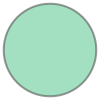

In [48]:
point0.buffer(1)

In [49]:
point0.buffer(1).area

3.13654849054594

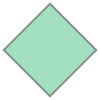

In [50]:
point0.buffer(1, resolution=1)

In [51]:
point0.buffer(1, resolution=1).area

2.0

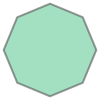

In [52]:
point0.buffer(1, resolution=2)

In [53]:
res_list = [10** x for x in range(8)]
for res in res_list:
    print(point0.buffer(1, resolution=res).area)

2.0
3.1286893008046204
3.1414634623641327
3.1415913616617597
3.1415926406704755
3.141592653460549
3.1415926535884404
3.1415926535895258


### LineString

In [54]:
first_line_string = LineString([point0, point1])

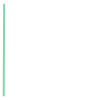

In [55]:
first_line_string

In [56]:
print(point0.x)
print(point0.y)
print('- '* 10)
print(point1.x)
print(point1.y)

121.52092997055541
25.088019988074905
- - - - - - - - - - 
121.52075001109426
25.049939996120486


In [57]:
# get info of point0
print(first_line_string.xy)
print(type(first_line_string))
print(first_line_string.area)
print(first_line_string.bounds) # minx, miny, maxx, maxy
print(first_line_string.geom_type)
print(first_line_string.is_valid)
print(first_line_string.length)
print(first_line_string.centroid)

(array('d', [121.52092997055541, 121.52075001109426]), array('d', [25.088019988074905, 25.049939996120486]))
<class 'shapely.geometry.linestring.LineString'>
0.0
(121.52075001109426, 25.049939996120486, 121.52092997055541, 25.088019988074905)
LineString
True
0.03808041718070139
POINT (121.52083999082485 25.068979992097695)


### Polygon

In [58]:
# get lat and lng of addr_2
addr_2 = dis_longterm.loc[2, 'address']
addr_2_info = geocoder.arcgis(addr_2)
addr_2_lng = addr_2_info.json['lng']
addr_2_lat = addr_2_info.json['lat']
point2 = Point(addr_2_lng, addr_2_lat)

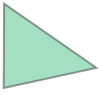

In [59]:
first_polygon = Polygon((point0, point1, point2))
first_polygon

## GeoSeries

In [60]:
# define a geoseries
s = gpd.GeoSeries(
    [
        Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
        Polygon([(10, 0), (10, 5), (0, 0)]),
        Polygon([(0, 0), (2, 2), (2, 0)]),
        LineString([(0, 0), (1, 1), (0, 1)]),
        Point(0, 1)
    ]
)

In [61]:
s.length

0     4.000000
1    26.180340
2     6.828427
3     2.414214
4     0.000000
dtype: float64

In [62]:
s.area

0     1.0
1    25.0
2     2.0
3     0.0
4     0.0
dtype: float64

In [63]:
s.bounds

,minx,miny,maxx,maxy
0,0.0,0.0,1.0,1.0
1,0.0,0.0,10.0,5.0
2,0.0,0.0,2.0,2.0
3,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,1.0


In [64]:
s.boundary

0    LINESTRING (0.00000 0.00000, 0.00000 1.00000, ...
1    LINESTRING (10.00000 0.00000, 10.00000 5.00000...
2    LINESTRING (0.00000 0.00000, 2.00000 2.00000, ...
3        MULTIPOINT (0.00000 0.00000, 0.00000 1.00000)
4                             GEOMETRYCOLLECTION EMPTY
dtype: geometry

In [65]:
s.total_bounds

array([ 0.,  0., 10.,  5.])

In [66]:
s.geom_type

0       Polygon
1       Polygon
2       Polygon
3    LineString
4         Point
dtype: object

In [67]:
s.distance(Point(-1, -1))

0    1.414214
1    1.414214
2    1.414214
3    1.414214
4    2.236068
dtype: float64

## GeoDataFrame

In [68]:
d = {
    'col1': ['name1', 'name2'],
    'geometry': [Point(1, 2), Point(2, 1)]
}
gdf = gpd.GeoDataFrame(d, crs='EPSG:4326', geometry='geometry')
gdf

,col1,geometry
0,name1,POINT (1.00000 2.00000)
1,name2,POINT (2.00000 1.00000)


###  crs (Coordinate Reference System)
The coordinate reference system (CRS) is important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth.

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection. This can be referred to using the authority code **"EPSG:4326"**.

In Taiwan, the commonly used Coordinate Reference System (CRS) is **"EPSG:3826.**" After converting from EPSG:4326 to EPSG:3826, the units for its x and y coordinates become **meter**.

In [69]:
# get 臺北市區界圖 from data.taipei
URL = 'https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=d8b7eb29-136f-49fc-b14b-3489d3656122'
FILE_NAME = 'tpe_district_border.zip'
!wget $URL -O $FILE_NAME
!unzip -d tpe_district_border -O BIG5 $FILE_NAME

--2023-11-04 10:04:24--  https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=d8b7eb29-136f-49fc-b14b-3489d3656122
Resolving data.taipei (data.taipei)... 210.69.108.244, 2001:4420:6006:157::32
Connecting to data.taipei (data.taipei)|210.69.108.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172949 (169K) [application/zip]
Saving to: ‘tpe_district_border.zip’

tpe_district_border 100%[===================>] 168.90K   208KB/s    in 0.8s    

2023-11-04 10:04:25 (208 KB/s) - ‘tpe_district_border.zip’ saved [172949/172949]

Archive:  tpe_district_border.zip
  inflating: tpe_district_border/G97_A_CADIST_P.dbf  
  inflating: tpe_district_border/G97_A_CADIST_P.shp  
  inflating: tpe_district_border/G97_A_CADIST_P.shx  


In [70]:
district_border = gpd.read_file('tpe_district_border', encoding='utf-8')
district_border.head(2)

,AREA,PERF_ID,COUN_ID,CPID,CPTID,NPID,NPTID,PNAME,TNAME,PTNAME,TM2_MAX_X,TM2_MAX_Y,TM2_MIN_X,TM2_MIN_Y,MAX_X,MAX_Y,MIN_X,MIN_Y,geometry
0,5.738380e+07,63012.0,6301200,63012,6301200,63012.0,6301200.0,臺北市,北投區,臺北市北投區,307802.1700,2.789176e+06,296266.0530,2.776476e+06,121.57361,25.21014,121.45871,25.09588,"POLYGON ((302675.668 2785251.546, 302675.502 2..."
1,6.110781e+07,63011.0,6301100,63011,6301100,63011.0,6301100.0,臺北市,士林區,臺北市士林區,311328.6318,2.787546e+06,296551.1512,2.774091e+06,121.60853,25.19528,121.46145,25.07434,"POLYGON ((307802.170 2787372.760, 307831.907 2..."


In [71]:
district_border.crs = 'EPSG:3826'
district_border.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan, Republic of China - between 120°E and 122°E, onshore and offshore - Taiwan Island.
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [72]:
district_border = district_border[['PTNAME', 'geometry']]
district_border.head(3)

,PTNAME,geometry
0,臺北市北投區,"POLYGON ((302675.668 2785251.546, 302675.502 2..."
1,臺北市士林區,"POLYGON ((307802.170 2787372.760, 307831.907 2..."
2,臺北市內湖區,"POLYGON ((310064.640 2778552.346, 310063.746 2..."


In [73]:
district_border.crs = 'EPSG:3826'
district_border.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan, Republic of China - between 120°E and 122°E, onshore and offshore - Taiwan Island.
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [74]:
district_border = district_border.to_crs('EPSG:4326')
district_border.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [75]:
district_border.head(3)

,PTNAME,geometry
0,臺北市北投區,"POLYGON ((121.52259 25.17489, 121.52259 25.174..."
1,臺北市士林區,"POLYGON ((121.57354 25.19386, 121.57383 25.194..."
2,臺北市內湖區,"POLYGON ((121.59560 25.11414, 121.59559 25.114..."


In [76]:
dis_longterm

,_id,_importdate,type,name,address,tel,town
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,士林區
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,中山區
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,松山區
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933,信義區


In [77]:
# set column 'geometry'
dis_longterm['geometry'] = dis_longterm['address'].apply(
    lambda x: Point(
        geocoder.arcgis(x).json['lng'],
        geocoder.arcgis(x).json['lat']
    )
)

# from pd to gpd
dis_longterm = gpd.GeoDataFrame(
    dis_longterm,
    crs='EPSG:4326'
)

# change crs
dis_longterm = dis_longterm.to_crs('EPSG:3826')

In [78]:
# get distance (unit = m)
dis_longterm.loc[0, 'geometry'].distance(
    dis_longterm.loc[1, 'geometry']
)

4218.0307886983055

In [79]:
dis_longterm

,_id,_importdate,type,name,address,tel,town,geometry
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,士林區,POINT (302545.613 2775628.160)
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,中山區,POINT (302543.704 2771410.130)
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,松山區,POINT (306760.234 2772437.213)
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933,信義區,POINT (307208.130 2769567.975)


## Manipulations

### Intersect
**E.g. get the districts which intersect with the first long-term institution with buffer 1000**

In [80]:
# change crs
district_border = district_border.to_crs('EPSG:3826')

# get buffer
dis_longterm['buffer'] = dis_longterm['geometry'].buffer(1000)
buffer0 = dis_longterm.loc[0, 'buffer']

In [81]:
# get the districts that intersect with buffer0
idx = buffer0.intersects(district_border['geometry'])
print(idx)
print('- '* 20)
print(district_border[idx].PTNAME.tolist())

0     False
1      True
2     False
3      True
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
Name: geometry, dtype: bool
- - - - - - - - - - - - - - - - - - - - 
['臺北市士林區', '臺北市中山區', '臺北市大同區']


### Overlay
Perform spatial overlay between two GeoDataFrames.

In [82]:
polys1 = gpd.GeoSeries(
    [
        Polygon([(0,0), (2,0), (2,2), (0,2)]),
        Polygon([(2,2), (4,2), (4,4), (2,4)])
    ]
)


polys2 = gpd.GeoSeries(
    [
        Polygon([(1,1), (3,1), (3,3), (1,3)]),
        Polygon([(3,3), (5,3), (5,5), (3,5)])
    ]
)


df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

<Axes: >

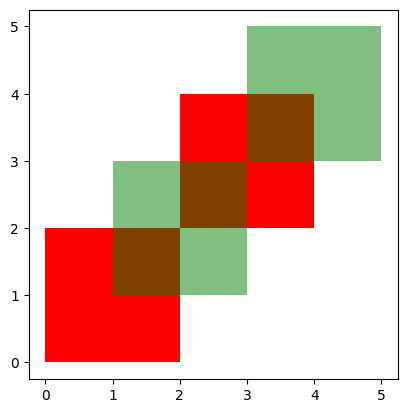

In [83]:
ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5)

In [84]:
# how='union'
res_union = df1.overlay(df2, how='union')
res_union

,df1,df2,geometry
0,1.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2.0,2.0,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."
3,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
4,2.0,NaN,"MULTIPOLYGON (((3.00000 3.00000, 4.00000 3.000..."
5,NaN,1.0,"MULTIPOLYGON (((2.00000 2.00000, 3.00000 2.000..."
6,NaN,2.0,"POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5...."


In [85]:
res_union.explode()

<ipython-input-85-1b6b855c193d>:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  res_union.explode()


df1  df2                                           geometry
0 0  1.0  1.0  POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1....
1 0  2.0  1.0  POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3....
2 0  2.0  2.0  POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3....
3 0  1.0  NaN  POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0....
4 0  2.0  NaN  POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4....
  1  2.0  NaN  POLYGON ((3.00000 3.00000, 2.00000 3.00000, 2....
5 0  NaN  1.0  POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....
  1  NaN  1.0  POLYGON ((2.00000 2.00000, 1.00000 2.00000, 1....
6 0  NaN  2.0  POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5....

<Axes: >

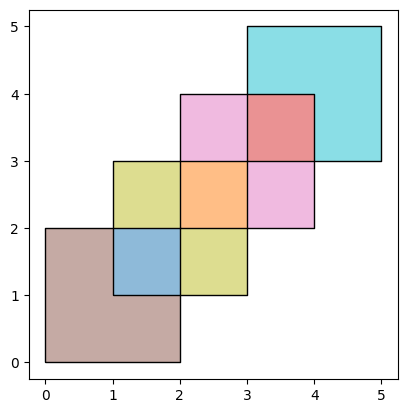

In [86]:
ax = res_union.plot(alpha=0.5, cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k')
df2.plot(ax=ax, facecolor='none', edgecolor='k')

In [87]:
# how='intersection'
res_intersection = df1.overlay(df2, how='intersection')
res_intersection

,df1,df2,geometry
0,1,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2,1,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2,2,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."


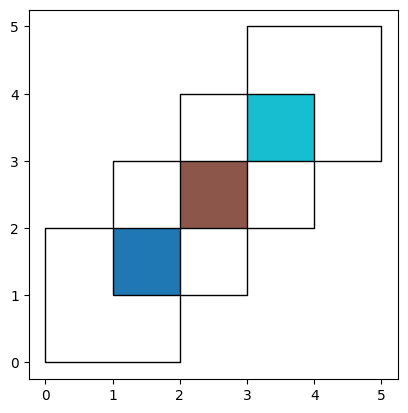

In [88]:
ax = res_intersection.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');


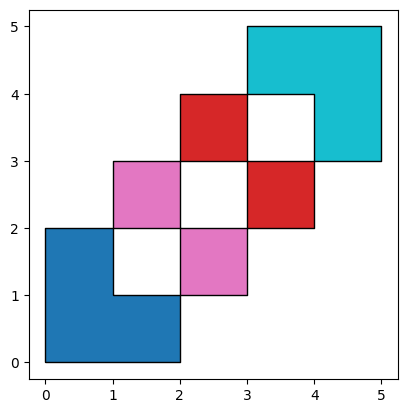

In [89]:
'''
how='symmetric_difference'
the opposite of 'intersection'
'''
res_symdiff = df1.overlay(df2, how='symmetric_difference')
ax = res_symdiff.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

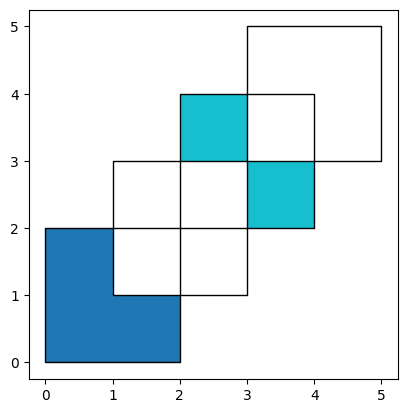

In [90]:
'''
how='difference'
obtain the geometries that are part of df1 but are not contained in df2
'''
res_difference = df1.overlay(df2, how='difference')
ax = res_difference.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

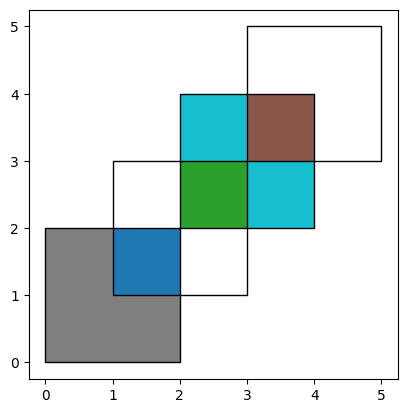

In [91]:
'''
how='identity'
the result consists of the surface of df1,
but with the geometries obtained from overlaying df1 with df2
'''
res_identity = df1.overlay(df2, how='identity')
ax = res_identity.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');


### E.g. the overlap area between long-term care facilities with buffer and administrative districts

In [92]:
dis_longterm_buffer = dis_longterm[['name', 'buffer']]
dis_longterm_buffer = dis_longterm_buffer.set_geometry('buffer')

overlay_df = gpd.overlay(
    dis_longterm_buffer,
    district_border,
    how='union'
).explode()

overlay_df

<ipython-input-92-06137c802343>:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ).explode()


,,name,PTNAME,geometry
0,0,士林失能身障日照中心,臺北市士林區,"POLYGON ((303540.798 2775530.143, 303526.398 2..."
1,0,士林失能身障日照中心,臺北市中山區,"POLYGON ((303469.493 2775245.477, 303427.534 2..."
2,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區,"POLYGON ((303538.889 2771312.112, 303524.490 2..."
3,0,士林失能身障日照中心,臺北市大同區,"POLYGON ((302074.216 2774746.239, 302059.273 2..."
4,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市大同區,"POLYGON ((301548.520 2771312.112, 301543.704 2..."
5,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市中正區,"POLYGON ((303425.626 2770938.733, 303375.174 2..."
6,0,臺北市民生身障社區式長照機構（日間照顧）,臺北市內湖區,"POLYGON ((307755.419 2772339.196, 307741.020 2..."
7,0,臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區,"POLYGON ((307642.156 2771965.816, 307591.704 2..."
8,0,臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區,"POLYGON ((308203.315 2769469.958, 308188.915 2..."
9,0,臺北市信義身障社區式長照機構（日間照顧）,臺北市大安區,"POLYGON ((306227.345 2769372.884, 306212.945 2..."


In [93]:
overlay_df['geometry'].area

0   0    3.044400e+06
1   0    9.154184e+04
2   0    1.098532e+06
3   0    6.069314e+02
4   0    8.642152e+05
5   0    1.173800e+06
6   0    1.378886e+05
7   0    2.998660e+06
8   0    3.117763e+06
9   0    1.878498e+04
10  0    3.580674e-10
    1    2.728973e-09
11  0    7.626783e-09
    1    9.589520e-06
    2    2.968405e-01
    3    9.100289e-03
    4    1.314581e-01
    5    3.656399e-01
12  0    1.290124e-03
    1    5.995269e-04
    2    1.747762e-04
    3    1.852653e-06
    4    3.297013e-05
13  0    9.954848e-03
    1    6.510427e-03
    2    4.390402e-04
    3    4.906429e-03
    4    5.024801e-03
    5    1.686159e-04
14  0    5.738380e+07
15  0    5.789722e+07
    1    1.661904e+05
16  0    3.181394e+07
17  0    1.268632e+07
18  0    3.906514e+06
19  0    5.682794e+06
20  0    2.195662e+07
21  0    6.368075e+06
22  0    8.121732e+06
23  0    7.449655e+06
24  0    1.132080e+07
25  0    3.125012e+07
dtype: float64

# Kepler in Python

In [94]:
from keplergl import KeplerGl
from google.colab import output
output.enable_custom_widget_manager()

map_ = KeplerGl(height=700)
map_.add_data(
    data=overlay_df[overlay_df.area < 1],
    name='overlay_df'
)
map_.add_data(
    data=district_border,
    name='dist_border'
)
map_


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'overlay_df': {'index': [(10, 0), (10, 1), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5)…

# 儀表板資料格式轉換

For the input format of the dashboard, you can refer to this [link](https://tuic.gov.taipei/documentation/front-end/chart-data).

## save as GeoJson

**E.g. Combine 'dis_institution (身障設施)' and 'dis_longterm (身障社區長照機構)' into 'dis_friendly_institution (身障友善機構)'**

In [95]:
# 身障社區長照機構
dis_longterm.drop(['geometry'], axis=1, inplace=True)
dis_longterm.rename(columns={'buffer': 'geometry'}, inplace=True)
dis_longterm['fax'] = ''
dis_longterm['is_accessi'] = ''
dis_longterm['code'] = ['C01010001', 'C01010002', 'C01010003', 'C01010004']
dis_longterm.head(3)

,_id,_importdate,type,name,address,tel,town,geometry,fax,is_accessi,code
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,士林區,"POLYGON ((303545.613 2775628.160, 303540.798 2...",,,C01010001
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,中山區,"POLYGON ((303543.704 2771410.130, 303538.889 2...",,,C01010002
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,松山區,"POLYGON ((307760.234 2772437.213, 307755.419 2...",,,C01010003


In [96]:
# 身障設施
dis_institution.head(3)

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lng,lat,is_accessi,geometry
2,3,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.0,121.532379,25.111423,是,POINT (303689.900 2778225.000)
3,4,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.0,121.549477,25.110765,否,POINT (305415.200 2778159.000)
4,5,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.0,121.541206,25.135172,否,POINT (304569.600 2780859.000)


In [97]:
# change crs
dis_longterm = dis_longterm.to_crs('EPSG:4326')

In [98]:
dis_institution['geometry'] = dis_institution['geometry'].buffer(1000)
dis_institution = dis_institution.to_crs('EPSG:4326')

In [99]:
# 身障友善機構
dis_friendly_institution = pd.concat([dis_institution, dis_longterm])
dis_friendly_institution.head(3)

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lng,lat,is_accessi,geometry,_id,_importdate
2,3.0,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.0,121.532379,25.111423,是,"POLYGON ((121.54229 25.11139, 121.54224 25.110...",NaN,NaN
3,4.0,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.0,121.549477,25.110765,否,"POLYGON ((121.55940 25.11073, 121.55934 25.109...",NaN,NaN
4,5.0,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.0,121.541206,25.135172,否,"POLYGON ((121.55112 25.13513, 121.55107 25.134...",NaN,NaN


In [100]:
dis_friendly_institution.shape

(177, 17)

In [101]:
dis_friendly_institution.to_file(
    'dis_origin_radius.geojson',
    driver='GeoJSON'
)

In [102]:
dis_friendly_institution.head(3)

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lng,lat,is_accessi,geometry,_id,_importdate
2,3.0,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.0,121.532379,25.111423,是,"POLYGON ((121.54229 25.11139, 121.54224 25.110...",NaN,NaN
3,4.0,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.0,121.549477,25.110765,否,"POLYGON ((121.55940 25.11073, 121.55934 25.109...",NaN,NaN
4,5.0,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.0,121.541206,25.135172,否,"POLYGON ((121.55112 25.13513, 121.55107 25.134...",NaN,NaN


In [103]:
dis_friendly_institution['geometry'] = dis_friendly_institution['geometry'].centroid
dis_friendly_institution.to_file(
    'dis_origin_center.geojson',
    driver='GeoJSON'
)

<ipython-input-103-1a1b321461ff>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dis_friendly_institution['geometry'] = dis_friendly_institution['geometry'].centroid


## save as json

For the input format of the dashboard, you can refer to this [link](https://tuic.gov.taipei/documentation/front-end/chart-data).

### Two-Dimensional Data

**E.g. Calculate the number of dis_friendly_institution in each administrative district**

In [104]:
stat = dis_friendly_institution.groupby('town').size().to_dict()

In [105]:
specified_order = [
    '北投區', '士林區', '內湖區', '南港區',
    '松山區', '信義區', '中山區', '大同區',
    '中正區', '萬華區', '大安區', '文山區'
]

In [106]:
results = {
    'data': [
        {
            'name':'',
            'data': [
                {
                    'x': x,
                    'y': stat[x]
                }
                for x in specified_order
            ]
        }
    ]
}

In [107]:
results

{'data': [{'name': '',
   'data': [{'x': '北投區', 'y': 23},
    {'x': '士林區', 'y': 19},
    {'x': '內湖區', 'y': 12},
    {'x': '南港區', 'y': 11},
    {'x': '松山區', 'y': 15},
    {'x': '信義區', 'y': 12},
    {'x': '中山區', 'y': 21},
    {'x': '大同區', 'y': 14},
    {'x': '中正區', 'y': 13},
    {'x': '萬華區', 'y': 7},
    {'x': '大安區', 'y': 8},
    {'x': '文山區', 'y': 22}]}]}

In [108]:
with open('dis_friendly_institution.json', "w") as json_file:
    json.dump(results, json_file, ensure_ascii=False)

### Three-Dimensional Data

**E.g. Calculate the amount of each subsidy for each year**

In [109]:
# get Processed data "無障礙需求歷年趨勢"
RAW_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv'
FILE_NAME = '無障礙需求歷年趨勢.csv'
!wget $RAW_DATA_URL -O $FILE_NAME
disability_demand_trend = pd.read_csv(FILE_NAME, thousands=',')

--2023-11-04 10:04:41--  https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1511 (1.5K) [text/plain]
Saving to: ‘無障礙需求歷年趨勢.csv’

無障礙需求歷年趨勢. 100%[===================>]   1.48K  --.-KB/s    in 0s      

2023-11-04 10:04:41 (25.6 MB/s) - ‘無障礙需求歷年趨勢.csv’ saved [1511/1511]



### datetime format

The datetime format needs to comply with ISO 8601.

E.g. 2023-11-03T18:43:09Z

In [110]:
disability_demand_trend['年份'] = disability_demand_trend['年份'].str.replace('年', '-01-01')
disability_demand_trend['年份'] = convert_str_to_time_format(
    column=disability_demand_trend['年份'],
    from_format='y-m-d'
)
disability_demand_trend['年份'] = disability_demand_trend['年份'].map(
    lambda x: x.isoformat()
).str.replace('\+08:00', 'Z')

disability_demand_trend.head(3)

*H* not found, only *ymd*


<ipython-input-110-415584f8c034>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  ).str.replace('\+08:00', 'Z')


,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995-01-01T00:00:00Z,37007518,123629720,67958515
1,1996-01-01T00:00:00Z,91367929,265961218,59513472
2,1997-01-01T00:00:00Z,68788296,168770548,63790107


In [111]:
cols = list(disability_demand_trend)
cols.remove('年份')

results = {
    'data': [
        {
            'name': col,
            'data': [
                {
                    'x': x,
                    'y': y
                }
                for x, y in zip(
                    disability_demand_trend['年份'],
                    disability_demand_trend[col]
                )
            ]
        }
        for col in cols
    ]
}

with open('disability_demand_trend.json', "w") as json_file:
    json.dump(results, json_file, ensure_ascii=False)


In [112]:
results

{'data': [{'name': '日間及住宿式照顧補助金額(元)',
   'data': [{'x': '1995-01-01T00:00:00Z', 'y': 37007518},
    {'x': '1996-01-01T00:00:00Z', 'y': 91367929},
    {'x': '1997-01-01T00:00:00Z', 'y': 68788296},
    {'x': '1998-01-01T00:00:00Z', 'y': 174731400},
    {'x': '1999-01-01T00:00:00Z', 'y': 158774563},
    {'x': '2000-01-01T00:00:00Z', 'y': 405985325},
    {'x': '2001-01-01T00:00:00Z', 'y': 613709172},
    {'x': '2002-01-01T00:00:00Z', 'y': 683857039},
    {'x': '2003-01-01T00:00:00Z', 'y': 732591017},
    {'x': '2004-01-01T00:00:00Z', 'y': 596227191},
    {'x': '2005-01-01T00:00:00Z', 'y': 567746993},
    {'x': '2006-01-01T00:00:00Z', 'y': 575093412},
    {'x': '2007-01-01T00:00:00Z', 'y': 530348362},
    {'x': '2008-01-01T00:00:00Z', 'y': 629298222},
    {'x': '2009-01-01T00:00:00Z', 'y': 677897043},
    {'x': '2010-01-01T00:00:00Z', 'y': 745310746},
    {'x': '2011-01-01T00:00:00Z', 'y': 885733255},
    {'x': '2012-01-01T00:00:00Z', 'y': 965652889},
    {'x': '2013-01-01T00:00:00Z', 'y': 

# 自主練習

**原始資料集**
身障就業資源地圖_1120918

URL:https://data.taipei/dataset/detail?id=c5aafda8-ef14-4f66-a6b7-d5da995a14b5

備註:原始資料集之地址欄位填寫狀況較多，如同一欄位有多筆地址或門牌號碼有多筆的狀況，建議可依照自身考慮條件進行清理與優化。


In [113]:
# raw_data
rid = 'f26a4c04-771f-42f3-a028-1a7e89303509'
raw_accessibility_job_map = get_datataipei_api(rid)


In [114]:
raw_accessibility_job_map.head(3)

,_id,_importdate,seqno,year,name,type,business item,contact,address,telephone
0,1,"{'date': '2023-09-18 10:25:37.382011', 'timezo...",1,112,財團法人心路社會福利基金會,綜合障別,職業重建服務,劉雪蓉\n陳仕閎,基金會：臺北市中山區吉林路364號4樓\n辦公室：臺北市文山區萬和街8號1樓,2239-5319轉210、212
1,2,"{'date': '2023-09-18 10:25:37.398575', 'timezo...",2,112,財團法人伊甸社會福利基金會,綜合障別,職業重建服務,邱千祝\n黃俊瑜,基金會(公文)臺北市文山區萬美街1段55號3樓\n辦公室：臺北市南港區忠孝東路6段85號3樓,2788-2656
2,3,"{'date': '2023-09-18 10:25:37.400310', 'timezo...",3,112,財團法人第一社會福利基金會,綜合障別,職業重建服務,劉正凱\n郭黛琳,基金會(公文)：臺北市信義區信義路5段150巷342弄17之7號\n辦公室：臺北市信義區信義...,2722-4136轉880


**最終產出成果**

共有二個檔案，分為基本圖資(chart_data)與地圖圖資(map_data)


**地址清理上採取以下動作:**

(1)去除新北市的機構(2筆)

(2)同一欄位有多筆地址換行取代為空格

(3)若有基金會與辦公室地址，以基金會為主

(4)若存在多筆地址，暫取第一筆地址作為代表呈現(可依個人判斷優化操作)

(5)若geocoder無回傳經緯度欄位，暫先去除該筆資料(可依個人判斷優化操作)(1筆)

In [115]:
# 最終產出成果如下
# map_data
RAW_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Processed_by_ETL/map_data/Practice_accessibility_job_map.geojson'
FILE_NAME = 'Practice_accessibility_job_map.geojson'
!wget $RAW_DATA_URL -O $FILE_NAME
Practice_accessibility_job_map = gpd.read_file(FILE_NAME,encoding='utf-8')

--2023-11-04 10:04:45--  https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Processed_by_ETL/map_data/Practice_accessibility_job_map.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44579 (44K) [text/plain]
Saving to: ‘Practice_accessibility_job_map.geojson’

Practice_accessibil 100%[===================>]  43.53K  --.-KB/s    in 0.01s   

2023-11-04 10:04:45 (3.59 MB/s) - ‘Practice_accessibility_job_map.geojson’ saved [44579/44579]



In [116]:
Practice_accessibility_job_map.head(3)

,Year,name,type,business item,contact,telephone,address.1,lng,lat,geometry
0,112,財團法人心路社會福利基金會,綜合障別,職業重建服務,劉雪蓉\n陳仕閎,2239-5319轉210、212,臺北市中山區吉林路364號4樓,121.53021,25.06407,POINT (121.53021 25.06407)
1,112,財團法人伊甸社會福利基金會,綜合障別,職業重建服務,邱千祝\n黃俊瑜,2788-2656,臺北市文山區萬美街1段55號3樓,121.56812,25.00233,POINT (121.56812 25.00233)
2,112,財團法人第一社會福利基金會,綜合障別,職業重建服務,劉正凱\n郭黛琳,2722-4136轉880,臺北市信義區信義路5段150巷342弄17之7號,121.57053,25.02678,POINT (121.57053 25.02678)


In [117]:
# chart_data
RAW_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Processed_by_ETL/chart_data/Practice_accessibility_job_town.json'
FILE_NAME = 'Practice_accessibility_job_town.json'
!wget $RAW_DATA_URL -O $FILE_NAME
Practice_accessibility_job_town = json.load(open(FILE_NAME))

--2023-11-04 10:04:45--  https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Processed_by_ETL/chart_data/Practice_accessibility_job_town.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374 [text/plain]
Saving to: ‘Practice_accessibility_job_town.json’

Practice_accessibil 100%[===================>]     374  --.-KB/s    in 0s      

2023-11-04 10:04:45 (24.8 MB/s) - ‘Practice_accessibility_job_town.json’ saved [374/374]



In [118]:
Practice_accessibility_job_town

{'data': [{'name': '',
   'data': [{'x': '北投區', 'y': 6},
    {'x': '士林區', 'y': 2},
    {'x': '內湖區', 'y': 1},
    {'x': '南港區', 'y': 2},
    {'x': '松山區', 'y': 10},
    {'x': '信義區', 'y': 11},
    {'x': '中山區', 'y': 8},
    {'x': '大同區', 'y': 10},
    {'x': '中正區', 'y': 3},
    {'x': '萬華區', 'y': 6},
    {'x': '大安區', 'y': 11},
    {'x': '文山區', 'y': 7}]}]}